In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt
from pyvista import examples
from tqdm.notebook import tqdm 
from IPython.display import clear_output

pv.set_plot_theme('document')
pv.global_theme.jupyter_backend = 'panel'

In [3]:
#mesh = examples.download_foot_bones()
# https://www.sciencedirect.com/science/article/pii/S0034425721004922

In [4]:
# Calculating the distance of two measurement points
p1 = np.array([-3.03703e+01,  3.18325e+01,  3.70000e-03])
p2 = np.array([-2.68345e+01,  2.82087e+01,  2.80000e-03])
MITTAUSDATA = {}

In [5]:
pointcloud = []
f = open("tls_points.txt", "r")
for line in f:
    vector = line.strip().split('\t')
    vector = [float(p) for p in vector]
    pointcloud.append(vector)
f.close()
pointcloud = np.array(pointcloud)
scanner_p = np.array([0, 0, 1.5])
print("pointcloud points:", len(pointcloud))

pointcloud points: 177748


In [6]:
cut_pointcloud = pointcloud
"""
for p in pointcloud:
    if p[2] > 1: 
        cut_pointcloud.append(p)
"""
point = np.array([2,11.5,2.59])
cut_distance = np.array([np.sqrt(np.dot(p.T, p)) for p in cut_pointcloud])
cut_pointcloud_low = cut_pointcloud[(30<cut_distance) & (cut_distance<32)]
cut_pointcloud_mid = cut_pointcloud[(32<cut_distance) & (cut_distance<36)]
cut_pointcloud_high = cut_pointcloud[(36<cut_distance) & (cut_distance<40)]

leaf_distance = np.array([np.linalg.norm(p-point) for p in pointcloud])
print(len(leaf_distance), len(pointcloud))
leaf_pointcloud = pointcloud[(leaf_distance<0.45)]
print("leaf_pointcloud:", len(leaf_pointcloud))
print("cut_pointcloud_low:", len(cut_pointcloud_low), len(cut_pointcloud_mid), len(cut_pointcloud_high))
trunk_pointcloud = []
for p in pointcloud:
    if p[2] > 1.4 and p[2] < 1.7 and p[1] > 14 and p[0] > 0:
        trunk_pointcloud.append(p)

trunk_mesh = pv.PolyData(trunk_pointcloud)
mesh = pv.PolyData(cut_pointcloud)
mesh.plot(eye_dome_lighting=True, notebook=True)

pl = pv.Plotter()
pl.add_mesh(mesh, show_edges=True)
pl.enable_surface_picking()
pl.show()

177748 177748
leaf_pointcloud: 71
cut_pointcloud_low: 1061 1063 1059


In [36]:
# Lehden pinta-ala
leaf_mesh = pv.PolyData(leaf_pointcloud)
points = pv.wrap(leaf_mesh.points)
surf = points.reconstruct_surface()

print("mesh.area:", surf.area)
MITTAUSDATA['lehden pinta-ala'] = surf.area

#leaf_mesh.plot(eye_dome_lighting=True, notebook=True, render_points_as_spheres=True)
leaf_mesh.plot(    leaf_pointcloud,
    scalars=leaf_pointcloud[:, 2],
    render_points_as_spheres=True,
    point_size=30,
    show_scalar_bar=False
    )

mesh.area: 0.15980440809691573


In [10]:
# trunk_pointcloud
tmp = np.array(trunk_pointcloud)
#print(tmp)
tmp_low = []
tmp_mid = []
tmp_high = []
for p in tmp:
    if 1.3 < p[2] and p[2] < 1.45:
        tmp_low.append(p)#[p[0], 0, p[2]])
    if 1.45 < p[2] and p[2] < 1.55:
        tmp_mid.append(p)#[p[0], 0, p[2]])
    if 1.55 < p[2] and p[2] < 2:
        tmp_high.append(p)#[p[0], 0, p[2]])
        
tmp_low, tmp_mid, tmp_high = np.array(tmp_low), np.array(tmp_mid), np.array(tmp_high)

#print(tmp_low)
#print(tmp_mid)
#print(tmp_high)
low_ave = sum(tmp_low[:,2:])/len(tmp_low[:,2:])
mid_ave = sum(tmp_mid[:,2:])/len(tmp_mid[:,2:])
high_ave = sum(tmp_high[:,2:])/len(tmp_high[:,2:])
print("low_ave", low_ave)
print("mid_ave", mid_ave)
print("high_ave:", high_ave)
print("average:", (high_ave-low_ave)/2)
print("average:", (mid_ave-low_ave))
print("average:", (high_ave - mid_ave))
print("----")

print(tmp_low[0], tmp_mid[0], tmp_high[0])
trunk_angle_low = scanner_angle(tmp_low[0])
trunk_angle_mid = scanner_angle(tmp_mid[0])
trunk_angle_high = scanner_angle(tmp_high[0])
print(trunk_angle_low - trunk_angle_mid)
print(trunk_angle_high - trunk_angle_mid)
print(trunk_angle_high - trunk_angle_low)
#mesh = pv.PolyData(tmp_xy)
#mesh.plot(eye_dome_lighting=True, notebook=True)

tmp_angle_low = scanner_angle(cut_pointcloud_low[0])
tmp_angle_mid = scanner_angle(cut_pointcloud_mid[0])
tmp_angle_high = scanner_angle(cut_pointcloud_high[0])
"""
print(tmp_angle_low - tmp_angle_mid)
print(tmp_angle_mid - tmp_angle_high)
"""
scanner_aste_ero = (tmp_angle_low - tmp_angle_high)/2
print("Aaltojen välinen kulma-aste:", round(scanner_aste_ero,5), "rad")
print(scanner_aste_ero)
MITTAUSDATA['skannerin kerroksien aste-ero'] = scanner_aste_ero

low_ave [1.42535]
mid_ave [1.500275]
high_ave: [1.6126]
average: [0.093625]
average: [0.074925]
average: [0.112325]
----
[ 0.1428 14.9207  1.425 ] [ 0.1429 14.9355  1.4998] [ 0.1428 14.9263  1.5749]
0.005012911000317092
0.005004326345039943
-8.58465527714923e-06
Aaltojen välinen kulma-aste: 0.00444 rad
0.004435565396795703


In [11]:
tmp = sorted([x[0] for x in tmp_low[:,:1]])
print(tmp)
tmp = [ (tmp[x+1] - tmp[x]) for x in range(0, len(tmp), 2)]
print("pisteiden etäisyys\n", sum(tmp)/len(tmp))

[0.0124, 0.034, 0.0557, 0.0774, 0.0992, 0.1211, 0.1428, 0.1652]
pisteiden etäisyys
 0.021900000000000003


In [12]:
test = [ (p if p[2] < 2.5 else None) for p in leaf_pointcloud]
val_min = []
val_max = []
highest_point = 0

trunk = []
for p in pointcloud:
    if p[2] > highest_point:
        highest_point = p[2]
        
for p in leaf_pointcloud:
    if p[2] < 2.5:
        val_min.append(p)
        
    if p[2] > 2.9:
        val_max.append(p)

val_min = np.array(val_min)
val_max = np.array(val_max)
print(val_min)
print("------")
print(val_max)

asd = [np.linalg.norm(val_min[i][0] - val_min[i-1][0]) for i in range(1, len(val_min))]
print("vaakasuunta pisteväli", sum(asd)/len(asd))

[[ 2.2057 11.5576  2.4898]
 [ 2.188  11.556   2.4894]
 [ 2.1536 11.5585  2.4892]
 [ 2.1363 11.5592  2.489 ]
 [ 2.1712 11.5592  2.4894]
 [ 2.0829 11.5519  2.4879]
 [ 2.1171 11.5491  2.4881]
 [ 2.0982 11.5405  2.4873]]
------
[[ 2.115  11.5387  2.9032]]
vaakasuunta pisteväli 0.035100000000000096


In [13]:
print(highest_point)

13.8836


In [14]:
# Puun pituus
korkein_piste = 0
for p in pointcloud:
    if korkein_piste < p[2]:
        korkein_piste = p[2]
print(korkein_piste)

13.8836


In [15]:
# Pointcloud kulma-asteittain
def scanner_angle(p):
    p_scanner = np.array([0, 0, 1.5])
    v = p - p_scanner
    v_xyz = np.linalg.norm(v)
    v_xy = np.linalg.norm(v[:2])
    return np.arccos(v_xy/v_xyz)

#Cutting away points lower than or equal to 1.5
tmp = [ p[2] > 1.5 for p in pointcloud]
tmp_pointcloud = pointcloud[tmp]

pointcloud_angle = []
for p in tmp_pointcloud:
    angle_rad = scanner_angle(p)
    tmp = list(p) + [angle_rad]
    pointcloud_angle.append(tmp)

pointcloud_angle = np.array(pointcloud_angle)
print(pointcloud_angle[0])

[ 4.1811     13.6962      2.7335      0.08592511]


In [16]:
# Puun korkeus
highest_point = sorted(pointcloud_angle, key=lambda x : x[2], reverse=True)[0]
print("highest_point:\n", highest_point)
print("Puun korkeus:", highest_point[2])
aste_kulma = round(highest_point[3]/(2*np.pi) *360, 3)
print("aste_ero:", round(highest_point[3],3), aste_kulma)
MITTAUSDATA['puun korkeus'] = round(highest_point[2],3)
MITTAUSDATA['puun kulma skanneriin'] = highest_point[3]


highest_point:
 [ 0.3993     14.8991     13.8836      0.69328036]
Puun korkeus: 13.8836
aste_ero: 0.693 39.722


In [17]:
angle_layers = []
highest_point_angle = scanner_angle(highest_point[:3])
print("highest_point_angle:", highest_point_angle)
iangle = 0
for iangle in tqdm(np.arange(0, highest_point_angle+scanner_aste_ero, scanner_aste_ero)):
    start_angle = iangle
    end_angle = iangle + scanner_aste_ero
    tmp_bool = [ (start_angle < p[3] and p[3] <= end_angle) for p in pointcloud_angle]
    tmp = pointcloud_angle[tmp_bool]
    angle_layers.append([tmp])
    iangle += scanner_aste_ero

highest_point_angle: 0.6932803564942271


  0%|          | 0/158 [00:00<?, ?it/s]

In [18]:
print(len(angle_layers[0][0]))
print(len(angle_layers))
print(len(pointcloud_angle))

82
158
30517


Text(0, 0.5, 'Osuma (N)')

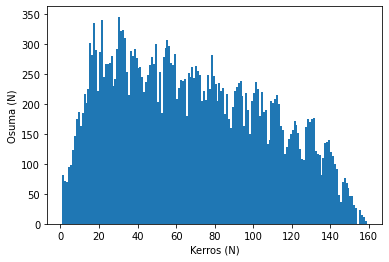

In [19]:
counts = [len(x[0]) for x in angle_layers]
#print(counts)
#print(len(counts))
#print(len(tmp))
plt.stairs(counts, [i+1 for i in range(len(counts)+1)], fill=True)
plt.xlabel('Kerros (N)')
plt.ylabel('Osuma (N)')
#plt.savefig('kerroksien_osumat_histogram.png')

In [20]:
highest_point_angle/scanner_aste_ero

156.30033478822335

In [21]:
# Scanneri kerroksien data
scanneri_aallon_leveys = 0 #
scanner_pisteita_per_kerros = 1100

layers_info = [[], #hit probabilities
               [], #layer width
              ]
for layer in angle_layers:
    tmp = sorted(layer[0], key=lambda x : x[0])
    tmp = np.array(tmp)
    hit_prob = len(tmp)
    
    if hit_prob > 0:
        width = tmp[-1][0] - tmp[0][0]
    else:
        width = 0
        
    layers_info[0].append(hit_prob)
    layers_info[1].append(width)

In [46]:
df = pd.DataFrame({"Osumat" : layers_info[0], "Leveys (m)" : layers_info[1]}, 
                  index=[i+1 for i in range(len(layers_info[0]))]
                 )

In [87]:
print(df)
df.to_csv("scanneri_kerroksien_data.csv")
df.to_excel("scanneri_kerroksien_data.xlsx")

     Osumat  Leveys (m)
1        82      3.9407
2        71      2.8185
3        70      4.4206
4        95      4.9200
5        98      5.8052
..      ...         ...
154       0      0.0000
155      23      1.1394
156      15      0.3989
157      11      0.3774
158       4      0.0649

[158 rows x 2 columns]


In [41]:
import pandas as pd


data = pd.read_csv('scanneri_kerroksien_data.csv').to_numpy()[:,1:]
for [prob, leveys] in data:
    print(prob, leveys)
    break

0.0745454545454545 3.9407


C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'Osuma (N)')

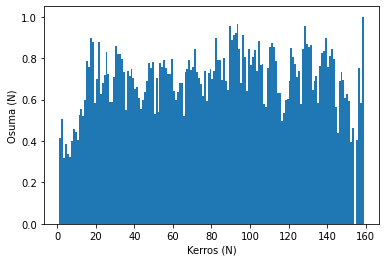

In [74]:
p = np.array(layers_info[1]) / 0.02
p = np.array(layers_info[0]) / p

counts = np.clip(p, 0, 1)
plt.stairs(counts, [i+1 for i in range(len(counts)+1)], fill=True)
plt.xlabel('Kerros (N)')
plt.ylabel('Osuma (N)')

In [85]:
MITTAUSDATA['dy'] = highest_point[2]/ len(layers_info[0])
MITTAUSDATA['dx'] = round(sum(tmp)/len(tmp), 5)

print(pd.DataFrame(MITTAUSDATA, index=[0]))

   lehden pinta-ala  skannerin kerroksien aste-ero  puun korkeus  \
0          0.159804                       0.004436        13.884   

   puun kulma skanneriin        dy      dx  
0                0.69328  0.087871  0.0219  


In [82]:
MITTAUSDATA

{'lehden pinta-ala': 0.15980440809691573,
 'skannerin kerroksien aste-ero': 0.004435565396795703,
 'puun korkeus': 13.884,
 'puun kulma skanneriin': 0.6932803564942271}

In [102]:
y = lambda x : -7E-06 * np.power(x,4) + 0.0025 * np.power(x,3) - 0.309 * np.power(x,2) + 14.04 * x + 73.175

In [104]:
y(1)

86.90849299999999